In [13]:
%pip install tensorflow
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install opencv-python
%pip install seaborn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [32]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 

import tensorflow as tf
import random
from cv2 import resize
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [15]:
'''from google.colab import drive
drive.mount('/content/drive')
import os
print(os.path.exists('/content/drive/MyDrive/solar_project/Faulty_solar_panel'))'''

dataset_path = r"C:\solar\Solar-Panel-Fault-Detection\Faulty_solar_panel"
import os
print(os.path.exists(dataset_path))



True


In [16]:
#from google.colab import drive
#drive.mount('/content/drive')
img_height = 244
img_width = 244
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

Found 885 files belonging to 6 classes.
Using 708 files for training.
Found 885 files belonging to 6 classes.
Using 177 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)
train_ds

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

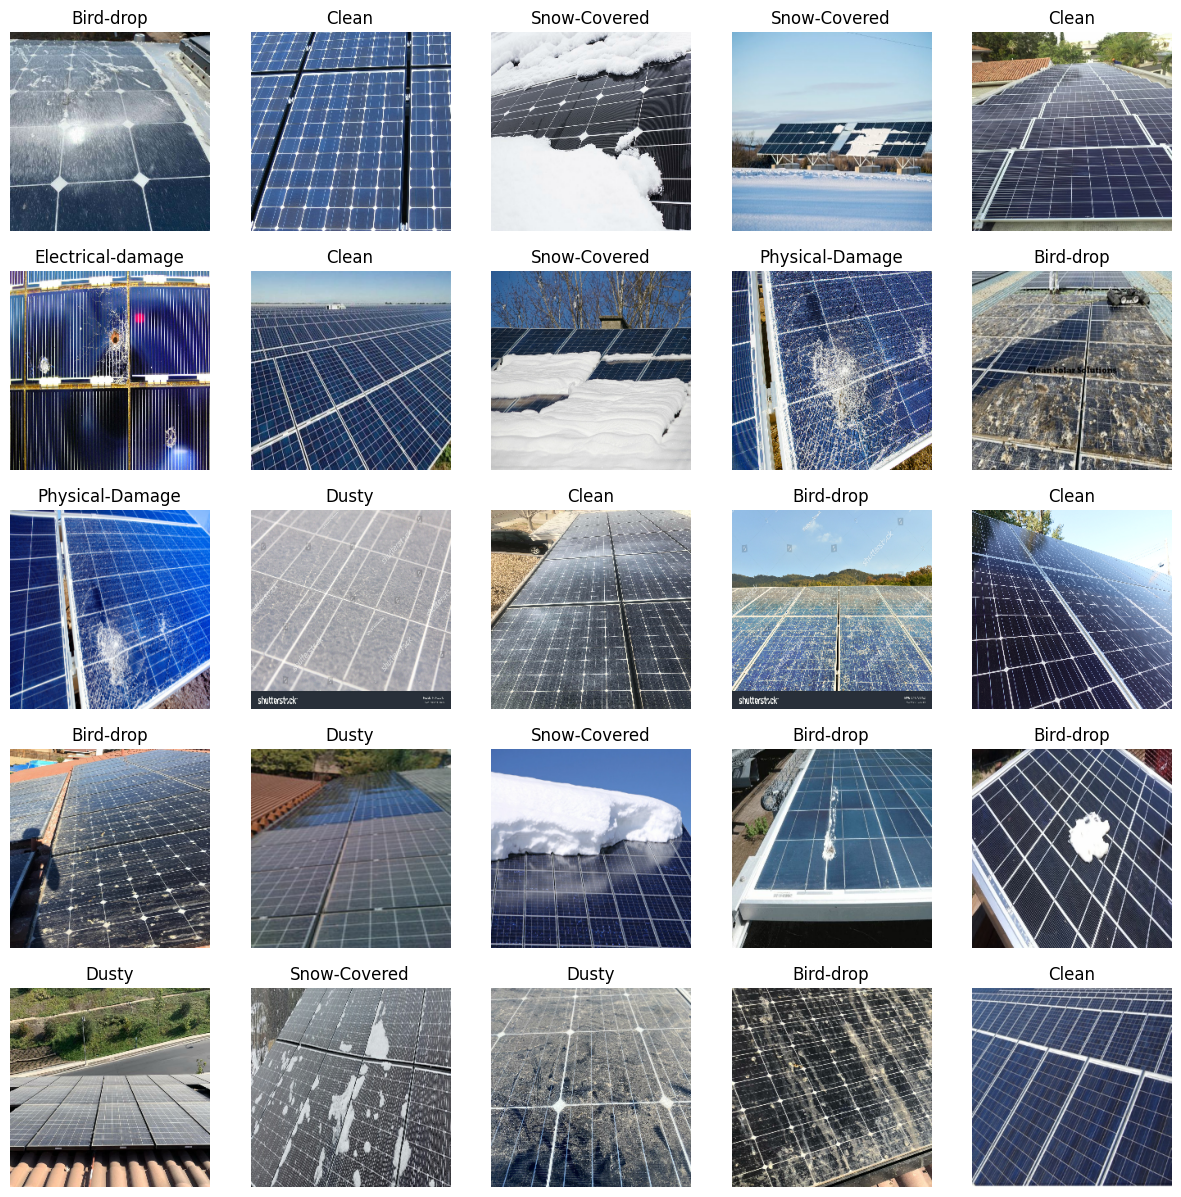

In [18]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Model Training

In [19]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False 

In [20]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(6)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 244, 244)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 244, 244)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 244, 244)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 244, 244,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 244, 244,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │     12,294 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
pip install pydot 


Note: you may need to restart the kernel to use updated packages.


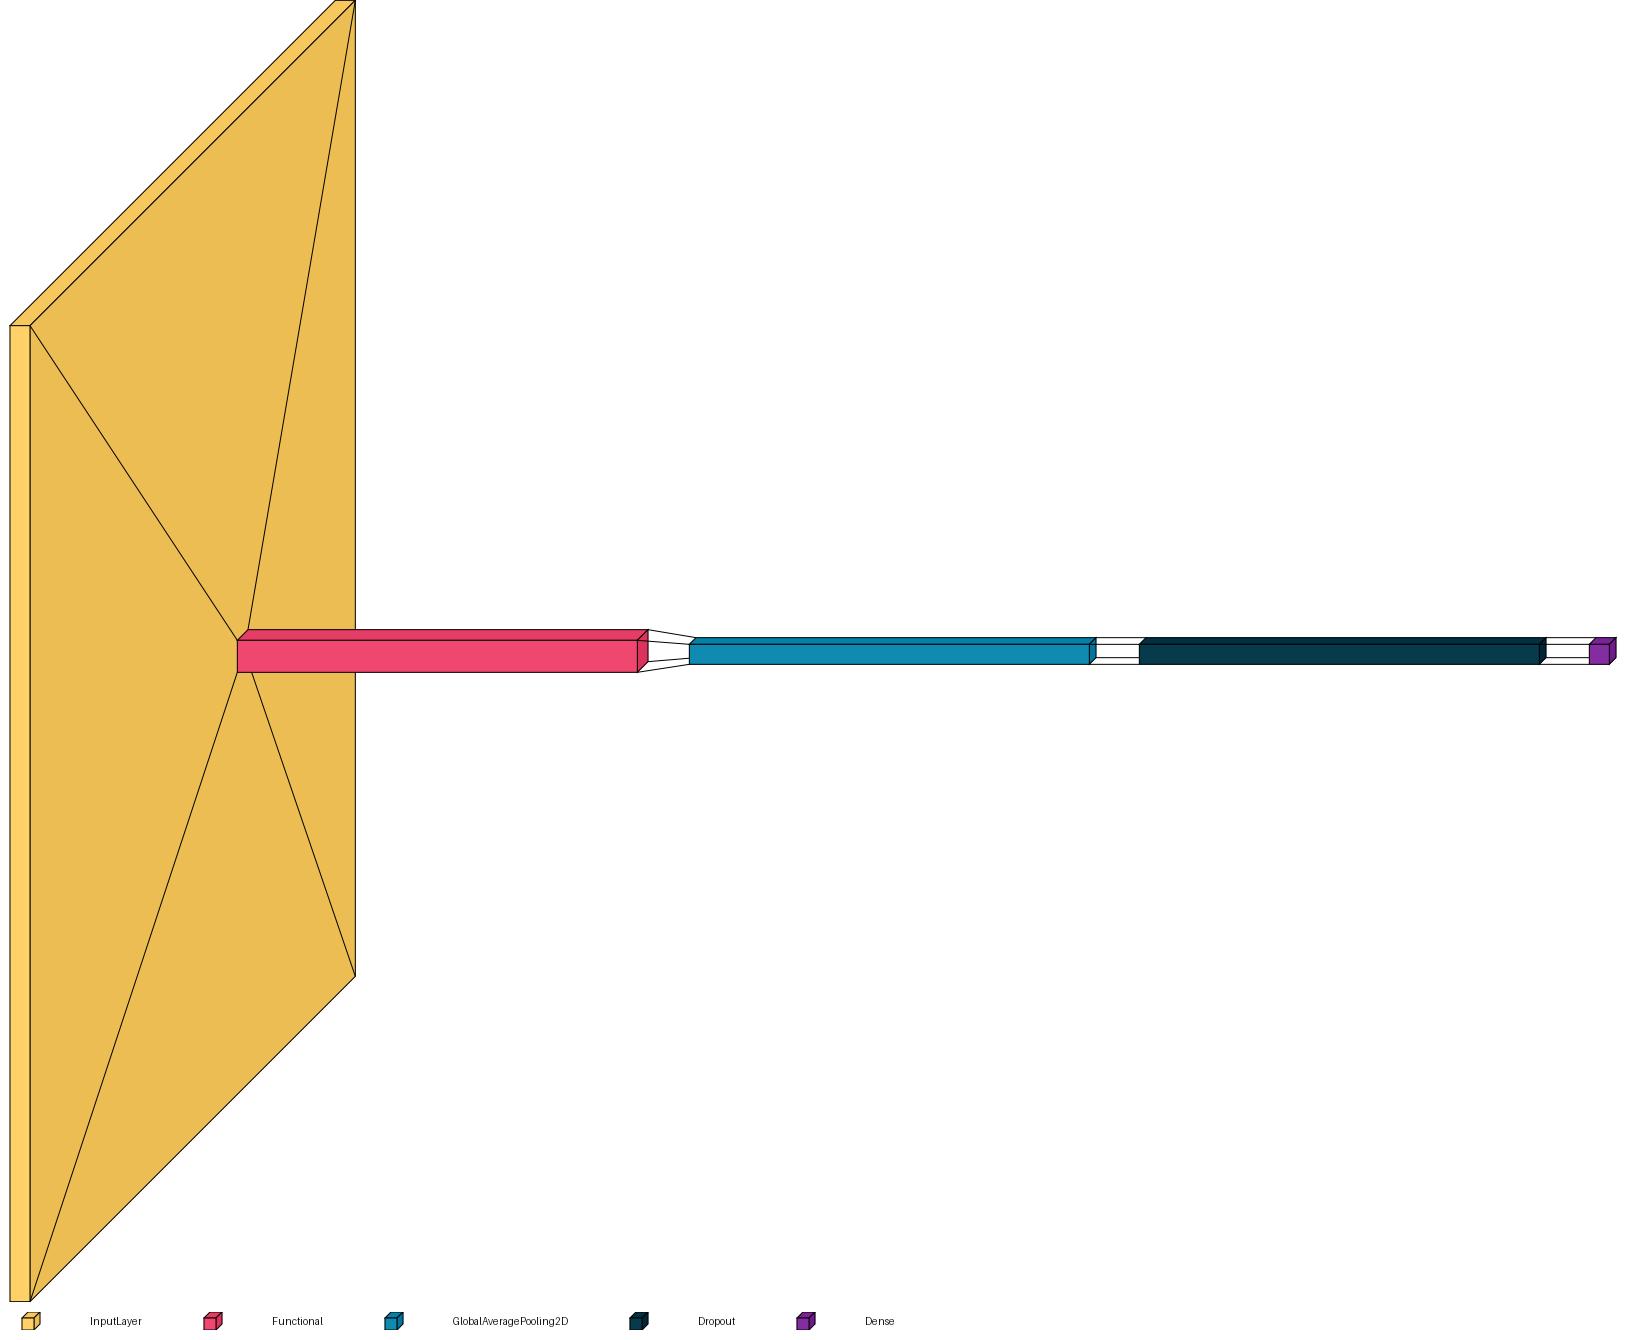

In [22]:
!pip install visualkeras
import visualkeras
import tensorflow as tf

def get_output_shape(self):
    if not hasattr(self, 'output'):
        return None
    if isinstance(self.output, list):
        return [tuple(o.shape) for o in self.output]
    return tuple(self.output.shape)

if not hasattr(tf.keras.layers.Layer, 'output_shape'):
    tf.keras.layers.Layer.output_shape = property(get_output_shape)
if not hasattr(tf.keras.layers.InputLayer, 'output_shape'):
    tf.keras.layers.InputLayer.output_shape = property(get_output_shape)

visualkeras.layered_view(model,legend=True,spacing=50,background_fill = 'white')

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
epoch = 15
model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4068 - loss: 1.6438 - val_accuracy: 0.6441 - val_loss: 0.9946
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6624 - loss: 0.9537 - val_accuracy: 0.7910 - val_loss: 0.6913
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7429 - loss: 0.7185 - val_accuracy: 0.8023 - val_loss: 0.6237
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7825 - loss: 0.5885 - val_accuracy: 0.7797 - val_loss: 0.6103
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8192 - loss: 0.5077 - val_accuracy: 0.7910 - val_loss: 0.5429
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8418 - loss: 0.4286 - val_accuracy: 0.8305 - val_loss: 0.4968
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8785 - loss: 0.3719 - val_accuracy: 0.8136 - val_loss: 0.5060
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8785 - loss: 0.3625 - val_accuracy: 0.8192 - val_loss:

In [25]:
#fine tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 244, 244)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 244, 244)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 244, 244)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 244, 244,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 244, 244,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │     12,294 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,624,596 (90.12 MB)

 Trainable params: 4,477,958 (17.08 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 24,590 (96.06 KB)

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
epoch = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epoch,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=3,
            verbose=1,
        )
    ]
)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8644 - loss: 0.4131 - val_accuracy: 0.7684 - val_loss: 0.7278
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9506 - loss: 0.1777 - val_accuracy: 0.8079 - val_loss: 0.5957
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9873 - loss: 0.0813 - val_accuracy: 0.8418 - val_loss: 0.5028
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9901 - loss: 0.0594 - val_accuracy: 0.8418 - val_loss: 0.5076
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9929 - loss: 0.0385 - val_accuracy: 0.8531 - val_loss: 0.4963
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9958 - loss: 0.0276 - val_accuracy: 0.8757 - val_loss: 0.4496
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9972 - loss: 0.0208 - val_accuracy: 0.8814 - val_loss: 0.4440
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9958 - loss: 0.0243 - val_accuracy: 0.8870 - val_loss:

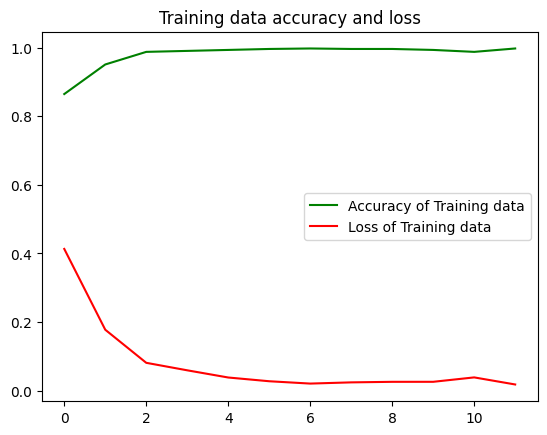

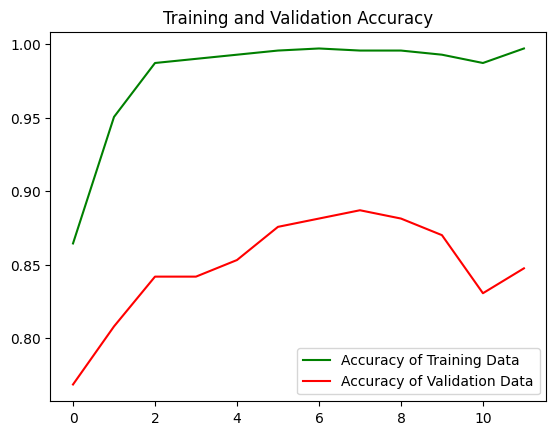

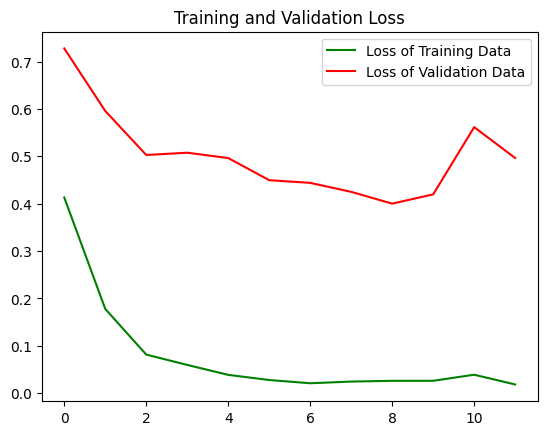

<Figure size 640x480 with 0 Axes>

In [28]:
get_ac = history.history['accuracy']
get_los = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 865ms/step - accuracy: 0.8475 - loss: 0.4964
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


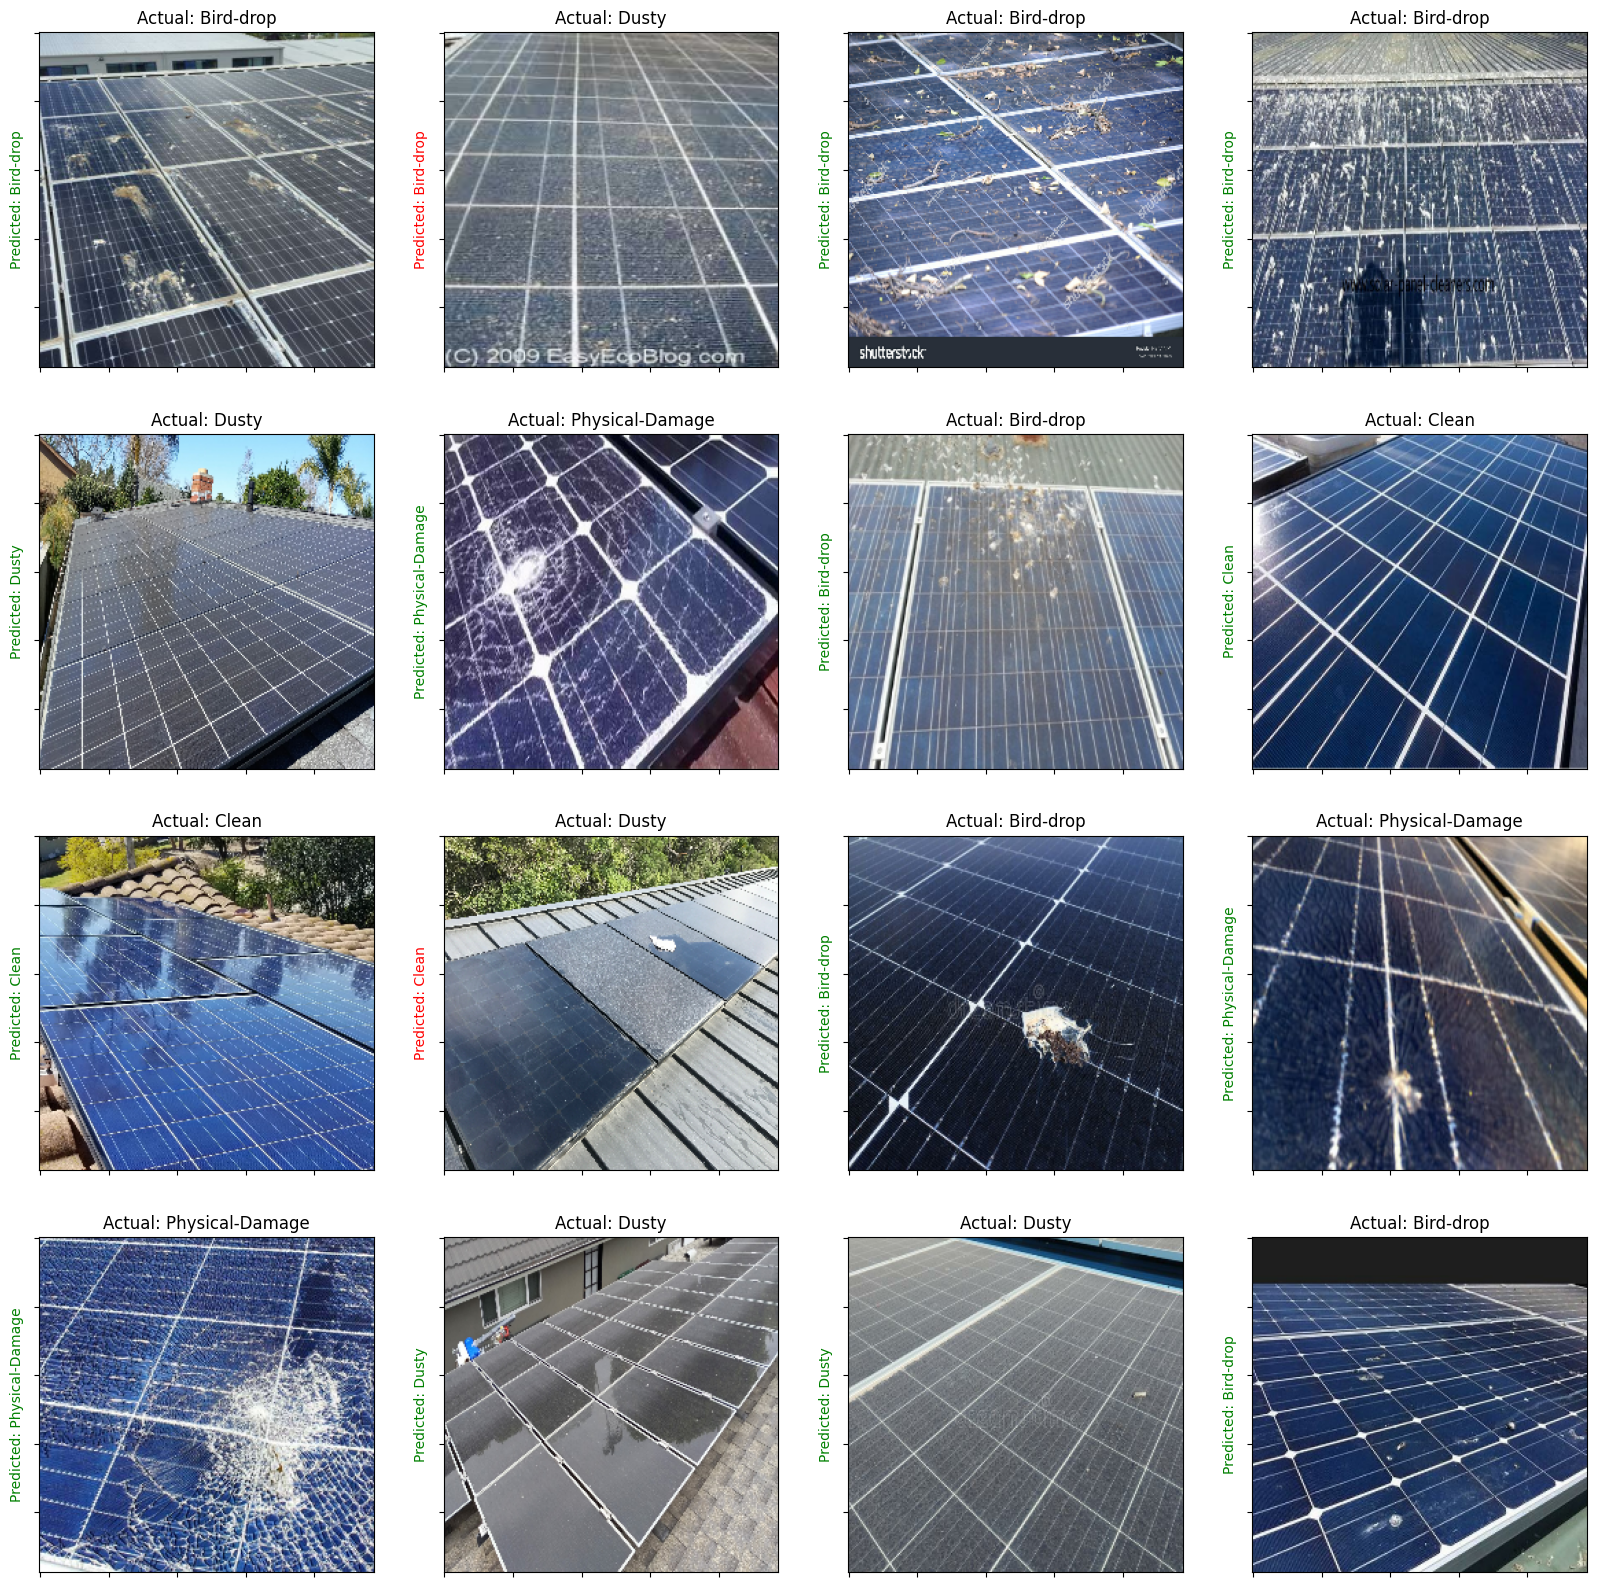

In [29]:
oss, accuracy = model.evaluate(val_ds)

plt.figure(figsize=(20, 20))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]]==class_names[np.argmax(score)]):
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)],fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

In [30]:
model.save('solar_fault_model.h5')
print("Model saved successfully")

Model saved successfully


Generating classification report and confusion matrix...

Classification Report:

                   precision    recall  f1-score   support

        Bird-drop       0.91      0.87      0.89        45
            Clean       0.75      0.88      0.81        34
            Dusty       0.77      0.77      0.77        43
Electrical-damage       0.87      0.81      0.84        16
  Physical-Damage       0.94      0.89      0.92        19
     Snow-Covered       1.00      0.90      0.95        20

         accuracy                           0.85       177
        macro avg       0.87      0.85      0.86       177
     weighted avg       0.85      0.85      0.85       177



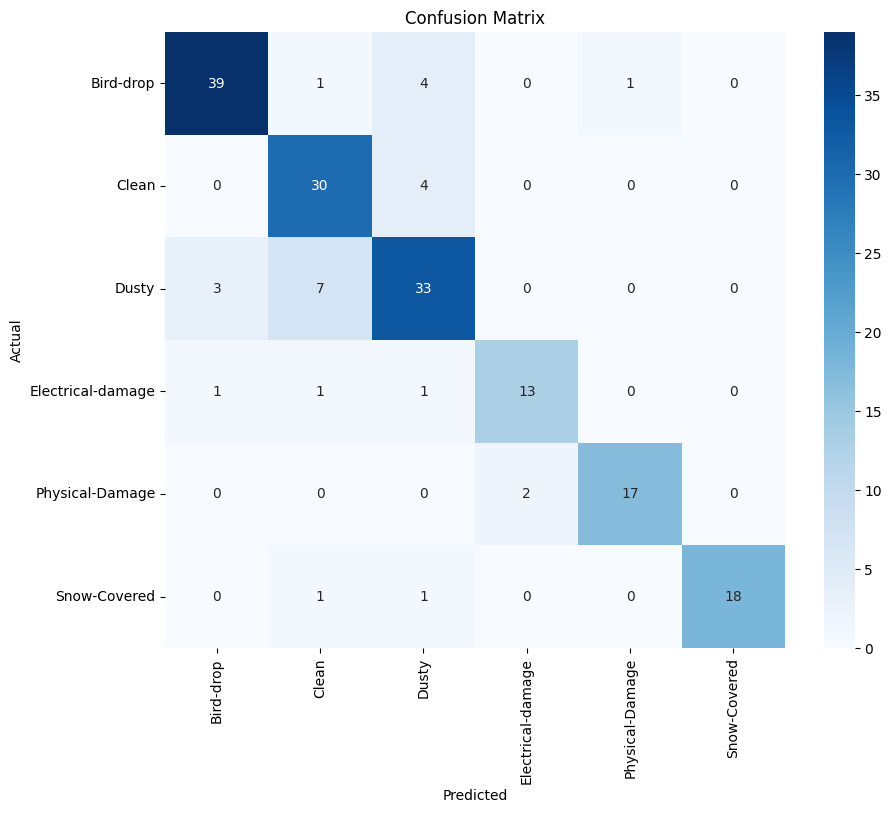

In [31]:

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get all labels and predictions for the validation set
print("Generating classification report and confusion matrix...")
y_true = []
y_pred = []

for x, y in val_ds:
    y_true.extend(y.numpy())
    preds = model.predict(x, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

# Display Classification Report (Includes Precision, Recall, and F1-score)
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n")
print(report)

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
